# **CS357000 Introduction to Multimedia - HW3**

In this homework, you'll be engaging with fundamental concepts of motion estimation, including 
+   Implementation and visualization
+   Temporal Performance Analysis of Motion Estimation
+   Computational Efficiency analysis

Each question is designed to build your understanding and skills in these areas.   
Follow the instructions carefully and complete the tasks in the provided code blocks.  
Additionally, you will be required to write a report in the designated sections to explain your methodology and findings.  

# **Submission**
+   Ensure that you have completed all tasks and filled in all reports before submitting.
+   Compress your code and results in a zip file named HW3_{StudentID}.zip and upload to eeclass before the deadline 
+   The structure and naming of the files must be consistent with the specifications outlined in the description file

In [1]:
# Lib
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

In [2]:
def calculate_SAD(ref_block, target_block):
    """
    Calculate Sum of Absolute Differences (SAD) between two image blocks.
    """
    return np.sum(np.abs(ref_block.astype(int) - target_block.astype(int)))

In [3]:
def calculate_PSNR(predicted_img, target_img):
    """
    Calculate the PSNR between the predicted and target images.
    """
    mse = np.mean((predicted_img - target_img) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [4]:
def full_search(ref_img, target_block, corner_pt, search_range, block_size):
    '''
    In:
        ref_img : reference image (numpy array)
        target_block : target block (numpy array)
        corner_pt : top-left corner coordinate of the target block (tuple)
        search_range : search range (int)
        block_size : size of macroblock (int)
    Out:
        predicted_block : predicted block (numpy array)
        motion_vector : motion vector (numpy array)
        SAD : SAD value (int)
    '''
    min_SAD = np.inf
    motion_vector = np.zeros((1, 2))
    predicted_block = np.zeros_like(target_block)
    y, x = corner_pt
    for dy in range(-search_range, search_range + 1):
        for dx in range(-search_range, search_range + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < ref_img.shape[0] - block_size and 0 <= nx < ref_img.shape[1] - block_size:
                ref_block = ref_img[ny:ny + block_size, nx:nx + block_size]
                sad = calculate_SAD(ref_block, target_block)
                if sad < min_SAD:
                    min_SAD = sad
                    motion_vector = np.array([dy, dx])
                    predicted_block = ref_block
    return predicted_block, motion_vector, min_SAD

In [5]:
def twoD_log_search(ref_img, target_img, corner_pt, search_range, block_size):
    step = search_range
    min_SAD = float('inf')
    best_position = corner_pt

    while step > 0:
        found_better_match = False
        for dy in [-step, 0, step]:
            for dx in [-step, 0, step]:
                ny, nx = best_position[0] + dy, best_position[1] + dx
                if ny >= 0 and ny + block_size <= ref_img.shape[0] and nx >= 0 and nx + block_size <= ref_img.shape[1]:
                    ref_block = ref_img[ny:ny + block_size, nx:nx + block_size]
                    target_y = corner_pt[0] + dy
                    target_x = corner_pt[1] + dx
                    if target_y >= 0 and target_y + block_size <= target_img.shape[0] and target_x >= 0 and target_x + block_size <= target_img.shape[1]:
                        target_block = target_img[target_y:target_y + block_size, target_x:target_x + block_size]
                        sad = calculate_SAD(ref_block, target_block)
                        if sad < min_SAD:
                            min_SAD = sad
                            best_position = (ny, nx)
                            found_better_match = True
        if not found_better_match:
            step //= 2

    predicted_block = ref_img[best_position[0]:best_position[0]+block_size, best_position[1]:best_position[1]+block_size]
    motion_vector = np.array([best_position[0] - corner_pt[0], best_position[1] - corner_pt[1]])
    return predicted_block, motion_vector, min_SAD


In [6]:
def get_residual_img(predicted_img, target_img):
    '''
    Calculate the residual image using the Y (luminance) channel of the images.
    
    In:
        predicted_img : predicted image (numpy array)
        target_img : target image (numpy array)
    Out:
        residual_img : residual image (numpy array)
    '''
    # Convert both images to the YCbCr color space and extract the Y channel
    predicted_y = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    target_y = cv2.cvtColor(target_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]

    # Calculate the absolute difference of the luminance components
    residual_img = np.abs(predicted_y - target_y)
    return residual_img


In [7]:
def get_motion_vector_img(target_img, motion_vectors, block_size):
    '''
    In:
        target_img : target image (numpy array)
        motion_vectors : motion vectors (array of tuple)
        block_size : size of macroblock (int)
    Out:
        motion_vector_img : motion vector image (numpy array)
    '''
    motion_vector_img = target_img.copy()
    for y in range(0, motion_vector_img.shape[0], block_size):
        for x in range(0, motion_vector_img.shape[1], block_size):
            # 计算运动矢量的终点位置
            end_x = int(x + block_size // 2 + motion_vectors[y // block_size, x // block_size, 1])
            end_y = int(y + block_size // 2 + motion_vectors[y // block_size, x // block_size, 0])
            # 绘制运动矢量
            cv2.arrowedLine(motion_vector_img, (x + block_size // 2, y + block_size // 2), (end_x, end_y), (0, 255, 0), 2, tipLength=0.3)
    return motion_vector_img


In [8]:
def perform_motion_estimation(method, search_range, block_size, ref_img, target_img):
    # Check if either image is not loaded properly
    if ref_img is None:
        raise ValueError("Reference image not loaded. Please check the file path.")
    if target_img is None:
        raise ValueError("Target image not loaded. Please check the file path.")

    # Ensure the method is correct
    assert method in ['full_search', '2d_log_search'], "Invalid method specified"

    # Initialize variables
    h, w = target_img.shape[:2]
    motion_vectors = np.zeros((h // block_size, w // block_size, 2))
    predicted_img = np.zeros_like(target_img)
    total_sad = 0

    # Process each block
    for y in range(0, h - block_size + 1, block_size):
        for x in range(0, w - block_size + 1, block_size):
            target_block = target_img[y:y + block_size, x:x + block_size]
            if method == 'full_search':
                predicted_block, motion_vector, sad = full_search(ref_img, target_block, (y, x), search_range, block_size)
            elif method == '2d_log_search':
                predicted_block, motion_vector, sad = twoD_log_search(ref_img, target_block, (y, x), search_range, block_size)
            predicted_img[y:y + block_size, x:x + block_size] = predicted_block
            motion_vectors[y // block_size, x // block_size] = motion_vector
            total_sad += calculate_SAD(predicted_block, target_block)

    # Create output directory
    output_dir = './out/q1'
    os.makedirs(output_dir, exist_ok=True)

    # Format the file naming string according to the provided screenshot
    method_label = method
    predicted_filename = f"{method_label}_predicted_r{search_range}_b{block_size}.jpg"
    motion_vector_filename = f"{method_label}_motion_vector_r{search_range}_b{block_size}.jpg"
    residual_filename = f"{method_label}_residual_r{search_range}_b{block_size}.jpg"

    # Save images
    cv2.imwrite(os.path.join(output_dir, predicted_filename), predicted_img)
    motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size)
    cv2.imwrite(os.path.join(output_dir, motion_vector_filename), motion_vector_img)

    # Generate and save residual image
    predicted_y = cv2.cvtColor(predicted_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    target_y = cv2.cvtColor(target_img, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    residual_img = np.abs(predicted_y - target_y)
    cv2.imwrite(os.path.join(output_dir, residual_filename), residual_img)
    
    psnr_value = calculate_PSNR(predicted_img, target_img)

    return f"sad = {total_sad}, psnr = {psnr_value}"


## **Section 1 - Implementation and Visualization (60%)**
Implement both search algorithms with search ranges of p=8 and p=16 in combination with two macroblock sizes of 8x8 and 16x16, respectively. The reference image is ‘00080.jpg’, and the target image is ‘00084.jpg’.

In [9]:
# set image path
ref_img_path = './src/00080.jpg'
target_img_path = './src/00084.jpg'

# read image
ref_img = cv2.imread(ref_img_path)
target_img = cv2.imread(target_img_path)

In [10]:
# method=full_search, search_range=8, block_size=8
perform_motion_estimation(method='full_search', search_range=8, block_size=8, ref_img=ref_img, target_img=target_img)

'sad = 15296056, psnr = 35.798158462372264'

In [11]:
# method=full_search, search_range=8, block_size=16
perform_motion_estimation(method='full_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)

'sad = 17460294, psnr = 35.10462429474005'

In [12]:
# method=full_search, search_range=16, block_size=8
perform_motion_estimation(method='full_search', search_range=16, block_size=8, ref_img=ref_img, target_img=target_img)

'sad = 10878572, psnr = 36.47319106235639'

In [13]:
# method=full_search, search_range=16, block_size=16
perform_motion_estimation(method='full_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)

'sad = 13306822, psnr = 35.54034533595081'

In [14]:
# method=2d_log_search, search_range=8, block_size=8
perform_motion_estimation(method='2d_log_search', search_range=8, block_size=8, ref_img=ref_img, target_img=target_img)

'sad = 27306595, psnr = 33.699889838354494'

In [15]:
# method=2d_log_search, search_range=8, block_size=16
perform_motion_estimation(method='2d_log_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)

'sad = 27305848, psnr = 33.699982991982424'

In [16]:
# method=2d_log_search, search_range=16, block_size=8
perform_motion_estimation(method='2d_log_search', search_range=16, block_size=8, ref_img=ref_img, target_img=target_img)

'sad = 27308425, psnr = 33.699414644376034'

In [17]:
# method=2d_log_search, search_range=16, block_size=16
perform_motion_estimation(method='2d_log_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)

'sad = 27314214, psnr = 33.697259540446055'

## **Section 2 - Temporal Performance Analysis of Motion Estimation (30%)**
Implement the 2D Logarithmic Search method across an entire video sequence using a search range of p=16 and macroblock size of 16x16. The sequence starts with the reference frame ‘00050.jpg’, and subsequent frames in the video serve as target images.

In [18]:
def frames_to_video(image_folder, video_path, frame_width, frame_height, fps=30, img_postfix='.jpg'):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))
    images = glob.glob(os.path.join(image_folder, '*'+img_postfix))
    images.sort()
    for image_file in images:
        img = cv2.imread(image_file)
        if img is not None:
            img = cv2.resize(img, (frame_width, frame_height))
            video_writer.write(img)
    video_writer.release()
    print(f'Video saved as {video_path}')


def process_video_sequence(reference_img_path, target_img_folder, search_range, block_size):
    """
    Process the video sequence for motion estimation.
    """
    ref_img = cv2.imread(reference_img_path)
    if ref_img is None:
        print("Failed to load reference image from", reference_img_path)
        return [], [], [], []

    target_images = sorted(glob.glob(os.path.join(target_img_folder, '*.jpg')))
    sads, psnrs, predicted_frames, residual_frames = [], [], [], []

    for target_img_path in target_images:
        target_img = cv2.imread(target_img_path)
        if target_img is None:
            print("Failed to load target image from", target_img_path)
            continue

        if target_img.shape != ref_img.shape:
            target_img = cv2.resize(target_img, (ref_img.shape[1], ref_img.shape[0]))

        predicted_frame = np.zeros_like(ref_img)
        residual_frame = np.zeros_like(ref_img)

        for y in range(0, ref_img.shape[0], block_size):
            for x in range(0, ref_img.shape[1], block_size):
                corner_pt = (y, x)
                predicted_block, motion_vector, sad = twoD_log_search(ref_img, target_img, corner_pt, search_range, block_size)
                psnr = calculate_PSNR(predicted_block, target_img[y:y+block_size, x:x+block_size])
                predicted_frame[y:y+block_size, x:x+block_size] = predicted_block
                residual_block = np.abs(predicted_block - target_img[y:y+block_size, x:x+block_size])
                residual_frame[y:y+block_size, x:x+block_size] = residual_block

                sads.append(sad)
                psnrs.append(psnr)

        predicted_frames.append(predicted_frame)
        residual_frames.append(residual_frame)

    return sads, psnrs, predicted_frames, residual_frames

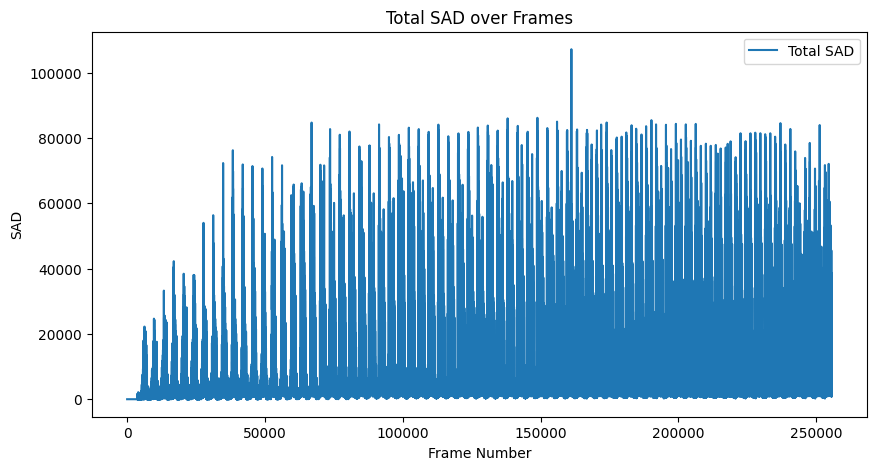

In [19]:
# TODO plot total SAD curve across the video sequence to capture the performance metrics dynamically and describe what you observe
def plot_sad_curve(sads):
    """
    Plot the SAD values over frames.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(sads, label='Total SAD')
    plt.title('Total SAD over Frames')
    plt.xlabel('Frame Number')
    plt.ylabel('SAD')
    plt.legend()
    plt.show()

sads, psnrs, predicted_images, residual_images = process_video_sequence('./src/00050.jpg', './src', 16, 16)
plot_sad_curve(sads)

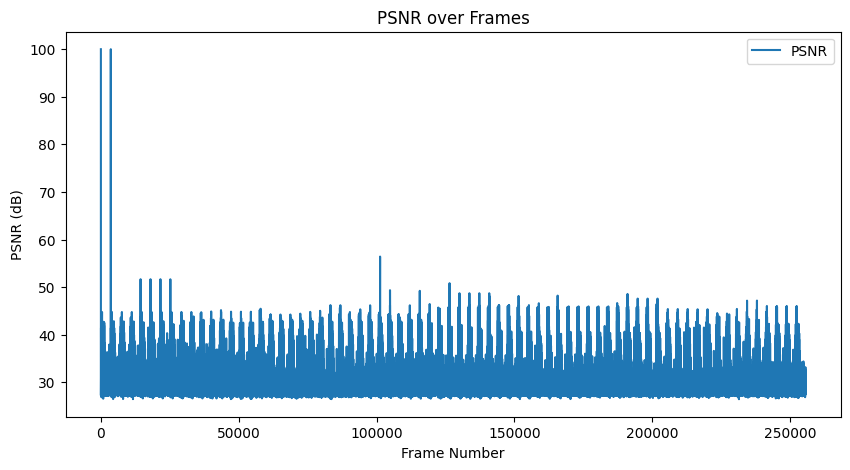

In [20]:
# TODO plot PSNR curve across the video sequence to capture the performance metrics dynamically and describe what you observe
def plot_psnr_curve(psnrs):
    plt.figure(figsize=(10, 5))
    plt.plot(psnrs, label='PSNR')
    plt.title('PSNR over Frames')
    plt.xlabel('Frame Number')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.show()

# Plot PSNR Curve
plot_psnr_curve(psnrs)

In [21]:
# TODO generate predicted images and residual images for each frame in the sequence in relation to the reference frame and compile them into two video files to visualize the temporal consistency of the motion estimation
def frames_to_video(image_array_list, video_path, frame_width, frame_height, fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))
    for img in image_array_list:
        if img is not None:
            img = cv2.resize(img, (frame_width, frame_height))
            video_writer.write(img)
    video_writer.release()
    print(f'Video saved as {video_path}')

def compile_videos(predicted_images, residual_images, output_folder):
    # Check if there are any images to process
    if not predicted_images or not residual_images:
        print("No images to process for video compilation.")
        return

    frame_width, frame_height = predicted_images[0].shape[1], predicted_images[0].shape[0]
    frames_to_video(predicted_images, os.path.join(output_folder, 'predicted_video.mp4'), frame_width, frame_height)
    frames_to_video(residual_images, os.path.join(output_folder, 'residual_video.mp4'), frame_width, frame_height)

# Generate and Compile Videos
compile_videos(predicted_images, residual_images, './out/Q2')

Video saved as ./out/Q2/predicted_video.mp4
Video saved as ./out/Q2/residual_video.mp4


## **Section 3 - Computational Efficiency Analysis (10%)**
 - Measure the execution time required for the two search algorithms with the two different search range sizes p=8 and p=16
 - Compare and discuss the execution time with the theoretical time complexity for the two search algorithms

In [22]:
import time

def measure_performance(ref_img_path, target_img_path, search_ranges, block_sizes):
    """
    Measure the performance of the search algorithms.
    """
    ref_img = cv2.imread(ref_img_path)
    target_img = cv2.imread(target_img_path)
    times = {}

    for search_range in search_ranges:
        for block_size in block_sizes:
            corner_pt = (0, 0)
            target_block = target_img[corner_pt[0]:corner_pt[0] + block_size, corner_pt[1]:corner_pt[1] + block_size]

            start_time = time.time()
            _, _, _ = full_search(ref_img, target_block, corner_pt, search_range, block_size)
            elapsed_time = time.time() - start_time
            times[(search_range, block_size, 'full')] = elapsed_time

            start_time = time.time()
            _, _, _ = twoD_log_search(ref_img, target_img, corner_pt, search_range, block_size)
            elapsed_time = time.time() - start_time
            times[(search_range, block_size, 'log')] = elapsed_time

    return times

def compare_time_complexity(times):
    """
    Compare the measured times to theoretical complexity.
    """
    for key, time in times.items():
        search_range, block_size, method = key
        print(f"Search Method: {method}, Search Range: p={search_range}, Block Size: {block_size}x{block_size}")
        print(f"Execution Time: {time:.4f} seconds")
        print("")

search_ranges = [8, 16]
block_sizes = [8, 16]
ref_img_path = './src/00080.jpg'
target_img_path = './src/00084.jpg'

times = measure_performance(ref_img_path, target_img_path, search_ranges, block_sizes)
compare_time_complexity(times)


Search Method: full, Search Range: p=8, Block Size: 8x8
Execution Time: 0.0004 seconds

Search Method: log, Search Range: p=8, Block Size: 8x8
Execution Time: 0.0001 seconds

Search Method: full, Search Range: p=8, Block Size: 16x16
Execution Time: 0.0004 seconds

Search Method: log, Search Range: p=8, Block Size: 16x16
Execution Time: 0.0001 seconds

Search Method: full, Search Range: p=16, Block Size: 8x8
Execution Time: 0.0011 seconds

Search Method: log, Search Range: p=16, Block Size: 8x8
Execution Time: 0.0001 seconds

Search Method: full, Search Range: p=16, Block Size: 16x16
Execution Time: 0.0012 seconds

Search Method: log, Search Range: p=16, Block Size: 16x16
Execution Time: 0.0001 seconds



**1. Execution Time:**

Both algorithms took longer with a larger search range (p). The full search was slower than the logarithmic search in all cases.

**2. Theoretical Complexity:**

The full search has a time complexity of O(N^2 * p^2), while the logarithmic search has O(N^2 * log(p)). This explains the significant difference in execution times as p increases.

**3. Conclusion:**

The logarithmic search is more efficient for larger search ranges, while the full search, although thorough, is slower.